# A long example of applying a high-pass filter through convolution

Sometimes computing the Fourier transform on a long stretch of data can become computationally difficult. In this case we may want to work on shorter data stretches. So let's think about approaching this differently: Remember how we said anything that we do in the frequency domain, can be done in the time domain? In the frequency-domain our high-pass filter is simply a multiplication operation: We multiply the frequency-domain data by our filter. In the time domain this is a *convolution* operation:

Here's the wikipedia page: https://en.wikipedia.org/wiki/Convolution, especially we are using the "Convolution Theorem". There are other resources on the web describing this as well, but let's just demonstrate it.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

In [2]:
# Sorry, this won't work for you! Please replace with the functions you wrote last week!

from fourier_transform import compute_fourier_transform, compute_inverse_fourier_transform


## Applying the high-pass filter in the time domain to our 8-second data stretch

In [3]:
# Here's our data from before, but *much* longer

# Choose data length and sampling rate
data_length = 1024
sample_rate = 16
sample_points = int(data_length * sample_rate)

times = np.arange(sample_points) / sample_rate
frequencies = np.arange(sample_points) * (sample_rate/sample_points)

np.random.seed(0)
data_time_domain = np.zeros(sample_points)
# Add low frequency noise: No components above 1Hz
for i in range(1,(data_length) + 1):
    # We generate a random number between 0 and 1 for the frequency,
    # This means it won't line up perfectly at the ends
    omega = np.random.uniform() * (2*np.pi)
    # randomly set the phase, so that it isn't all in the
    # imaginary frequency component!
    phase = np.random.random() * (2*np.pi)
    data_time_domain += 100 * np.sin(times * omega + phase)

# Add in a single 4Hz sine wave - random phase again
omega = 4. * (2*np.pi)
phase = np.random.random() * 2 * np.pi
signal = np.cos(times * omega + phase)
data_time_domain += signal


Text(0.5, 0, 'Frequency (Hz)')

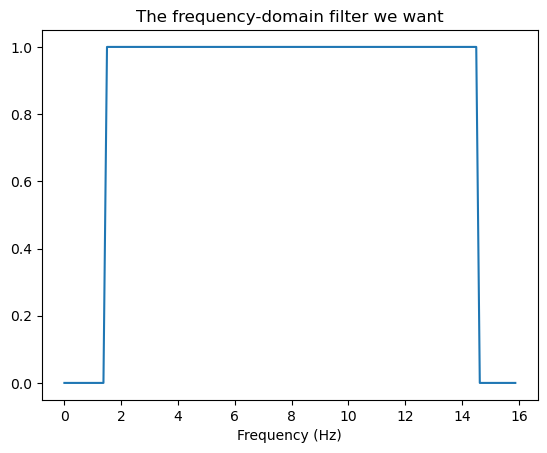

In [4]:
# We want to cut down our data to 8 seconds, so:
data_length_CUT = 8
sample_points_CUT = int(data_length_CUT * sample_rate)
data_time_domain_CUT = data_time_domain[504*sample_rate:(504+data_length_CUT)*sample_rate]
signal_CUT = signal[504*sample_rate:(504+data_length_CUT)*sample_rate]

times_CUT = np.arange(sample_points_CUT) / sample_rate
frequencies_CUT = np.arange(sample_points_CUT) * (sample_rate/sample_points_CUT)

# We want to apply the following "filter" to our data in the frequency domain
high_pass_filter = np.zeros(len(frequencies_CUT), dtype=np.complex128)
high_pass_filter[int(1.5*data_length_CUT):-(int(1.5*data_length_CUT) - 1)] = 1
plt.title("The frequency-domain filter we want")
plt.plot(frequencies_CUT, high_pass_filter.real)
plt.xlabel("Frequency (Hz)")


Text(0.5, 0, 'Times (s)')

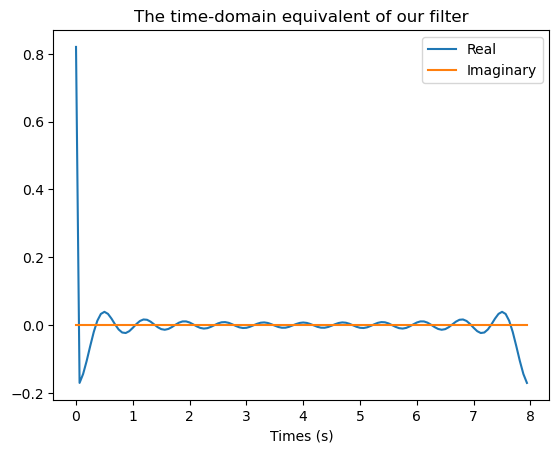

In [5]:
# Let plot this in the time domain
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)
plt.figure()
plt.title("The time-domain equivalent of our filter")
plt.plot(times_CUT, high_pass_filter_time_domain.real)
plt.plot(times_CUT, high_pass_filter_time_domain.imag)
plt.legend(['Real', 'Imaginary'])
plt.xlabel("Times (s)")


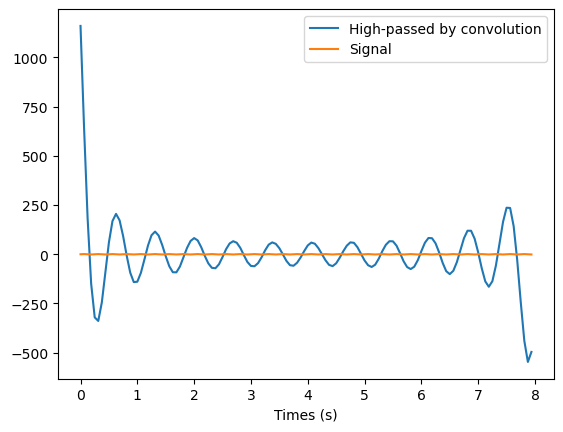

In [6]:
# To apply the high-pass-filter in the time-domain we use convolution.
# Here we continue to use the Fourier convention of assuming the data
# is cyclical!
high_passed_data = np.zeros(len(times_CUT))
# This is a convolution. There are numpy functions for this, but let's
# demonstrate it first
for i in range(len(times_CUT)):
    for j in range(0,len(high_pass_filter_time_domain)):
        k = i - j
        # This bit cycles the data
        if k < 0:
            k += len(high_pass_filter_time_domain)

        high_passed_data[i] += data_time_domain_CUT[j] * high_pass_filter_time_domain.real[k]


plt.figure()
plt.plot(times_CUT, high_passed_data, label='High-passed by convolution')
plt.plot(times_CUT, signal_CUT, label="Signal")
plt.xlabel("Times (s)")
plt.legend()


That doesn't look great - what could be wrong?

Text(0.5, 0, 'Frequency (Hz)')

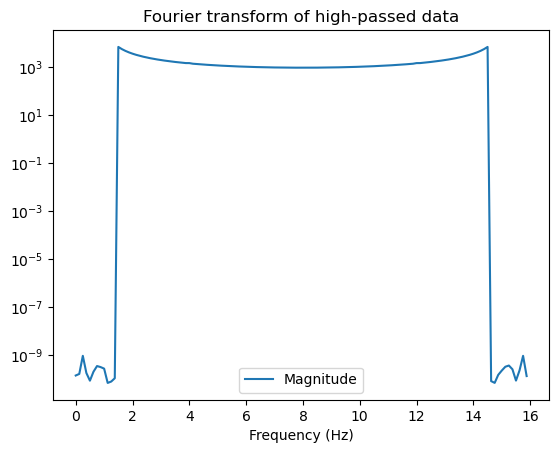

In [7]:
# Let's check the "high-passed" data in the frequency domain
high_passed_f_data = compute_fourier_transform(high_passed_data)
plt.figure()
plt.title("Fourier transform of high-passed data")
plt.semilogy(frequencies_CUT, abs(high_passed_f_data))
plt.legend(['Magnitude'])
plt.xlabel("Frequency (Hz)")

There's a bunch of stuff outside the filter still, and the 'plateau' of the filter is not right

## Applying the high-pass filter in the time-domain to the full data stretch

Let's now use the full set of data, and perform a convolution over a longer period of time.

In [8]:
# We want to apply the following "filter" to our data.
# Plotted in both f- and t- domains
# NO CHANGE FROM BEFORE!
high_pass_filter = np.zeros(len(frequencies_CUT), dtype=np.complex128)
high_pass_filter[int(1.5*data_length_CUT):-(int(1.5*data_length_CUT) - 1)] = 1

# Let get this in the time domain
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)

Text(0.5, 1.0, 'A time-shifted high pass filter')

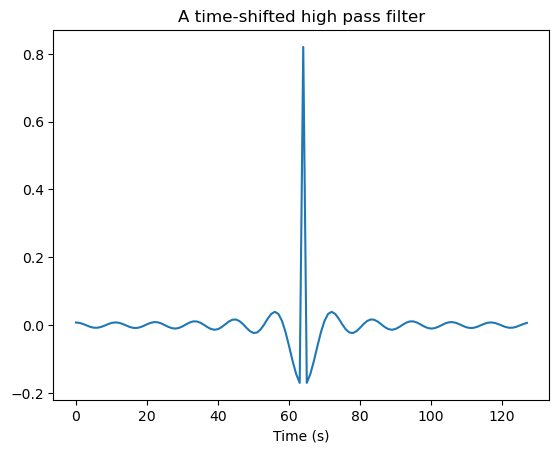

In [9]:
# The filter is cyclical in the time domain so we can shift it
# forward half the length of the data. We do this to put the
# peak of the filter in the middle, so that when we apply this
# to a longer stretch of data we minimize the effect
# of the discontinuity. We also remove the imaginary component,
# as it is 0 anyway
tmp = np.zeros(len(high_pass_filter_time_domain))
half_len = len(high_pass_filter_time_domain) // 2
tmp[half_len:] = high_pass_filter_time_domain[:half_len].real
tmp[:half_len] = high_pass_filter_time_domain[half_len:].real
high_pass_filter_time_domain = tmp
plt.figure()
plt.plot(high_pass_filter_time_domain)
plt.xlabel("Time (s)")
plt.title("A time-shifted high pass filter")


In [10]:
# To apply the high-pass-filter in the time-domain we use convolution.
# Now we do not assume the data is cyclical
high_passed_data = np.zeros(len(times) - len(high_pass_filter_time_domain))
# This is a convolution. There are numpy functions for this, but let's
# demonstrate it first
for i in range(len(high_passed_data)):
    for j in range(len(high_pass_filter_time_domain)):
        k = i + j
        high_passed_data[i] += high_pass_filter_time_domain[j] * data_time_domain[k]


Text(0, 0.5, 'Amplitude')

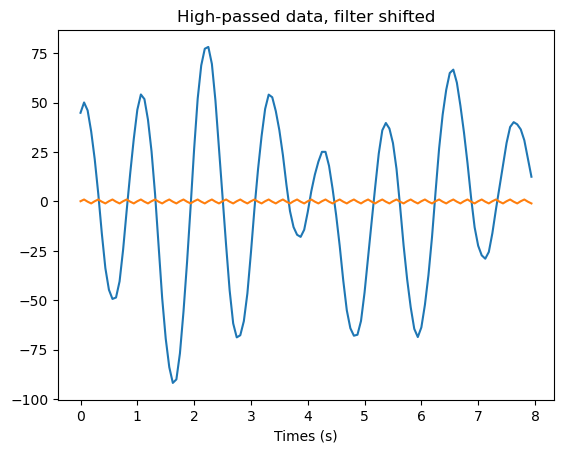

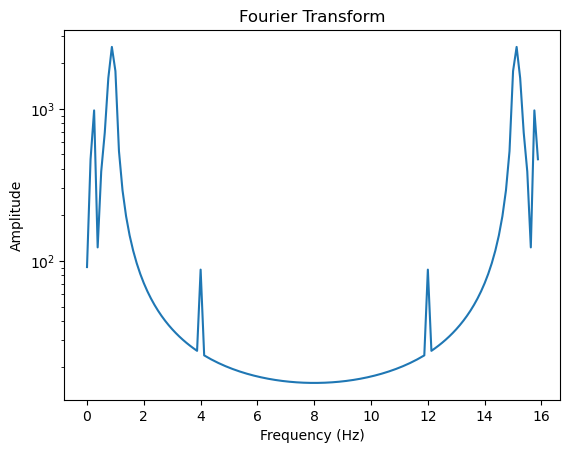

In [11]:
# Now let's plot an 8-second stretch of this data
high_passed_data_CUT = high_passed_data[504*sample_rate:(504+data_length_CUT)*sample_rate]

plt.figure()
plt.title("High-passed data, filter shifted")
plt.plot(times_CUT, high_passed_data_CUT, label="Data")
plt.plot(times_CUT, signal_CUT, label="Signal")
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(high_passed_data_CUT)
plt.semilogy(frequencies_CUT, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

Better but still not right

## We need a window!!

We're getting there! This did reduce the power of the low-frequency components of the data, but clearly it is still there, and we still can't easily see our 4Hz signal in the time domain. The issue here is still the same as what we saw in the previous notebook: the filter itself was generated assuming cyclical data, which this is not. Before we tried to alleviate this by applying a window to the data itself, but we can also apply the window to our high-pass filter. Let's illustrate that:

In [12]:
# We want to apply the following "filter" to our data.
# Plotted in both f- and t- domains
# and then rotated forward.
# NO CHANGE FROM BEFORE!
high_pass_filter = np.zeros(len(frequencies_CUT), dtype=np.complex128)
high_pass_filter[int(1.5*data_length_CUT):-(int(1.5*data_length_CUT) - 1)] = 1

# Let get this in the time domain
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)


# The filter is cyclical in the time domain so we can shift it forward 128 cycles. We do this to put the
# peak of the filter in the middle, so that when we apply this to a longer stretch of data we minimize the effect
# of the discontinuity. We also remove the imaginary component, as it's 0 anyway
tmp = np.zeros(len(high_pass_filter_time_domain))
half_len = len(high_pass_filter_time_domain) // 2
tmp[half_len:] = high_pass_filter_time_domain[:half_len].real
tmp[:half_len] = high_pass_filter_time_domain[half_len:].real
high_pass_filter_time_domain = tmp


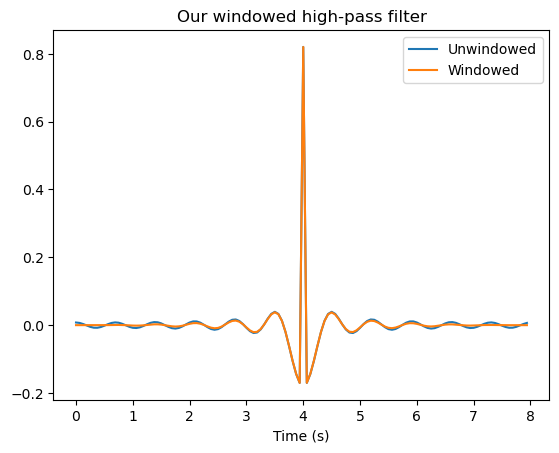

In [13]:
# Now we multiply our filter by a "Hann" window to force it to go to 0
# at the edges
high_pass_filter_windowed_time_domain = np.copy(high_pass_filter_time_domain)
for i in range(len(high_pass_filter_windowed_time_domain)):
    window_func = 0.5 * (1 - np.cos(2*np.pi*i/ (len(high_pass_filter_windowed_time_domain)-1) ) )
    high_pass_filter_windowed_time_domain[i] = high_pass_filter_windowed_time_domain[i] * window_func

plt.figure()
plt.title("Our windowed high-pass filter")
plt.plot(times_CUT, high_pass_filter_time_domain, label="Unwindowed")
plt.plot(times_CUT, high_pass_filter_windowed_time_domain, label="Windowed")
plt.xlabel("Time (s)")
plt.legend()


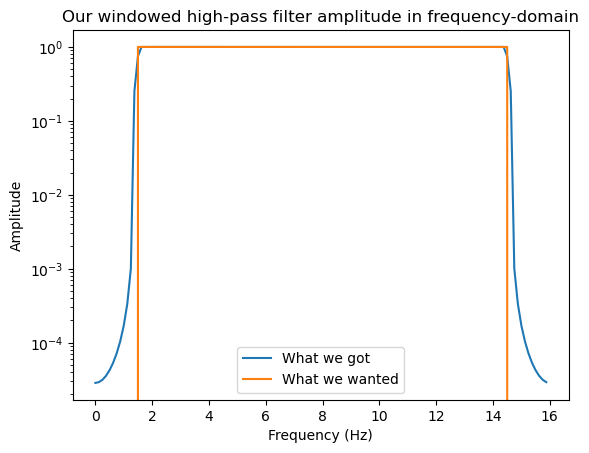

In [14]:
# What does this look like now in the frequency domain?
plt.figure()
data_frequency_domain = compute_fourier_transform(high_pass_filter_windowed_time_domain)
plt.semilogy(frequencies_CUT, abs(data_frequency_domain), label="What we got")
plt.semilogy(frequencies_CUT, high_pass_filter.real, label="What we wanted")
plt.title('Our windowed high-pass filter amplitude in frequency-domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend(loc='lower center')


That looks pretty good!

Text(0, 0.5, 'Amplitude')

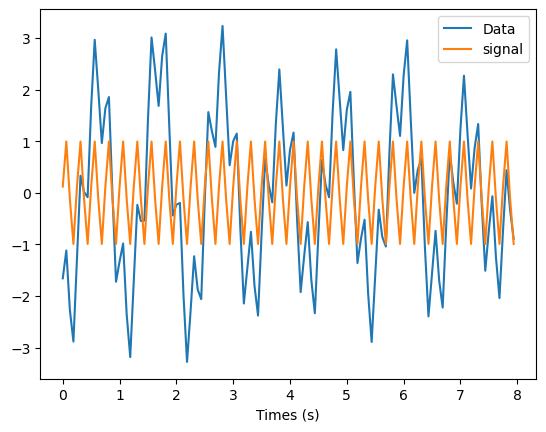

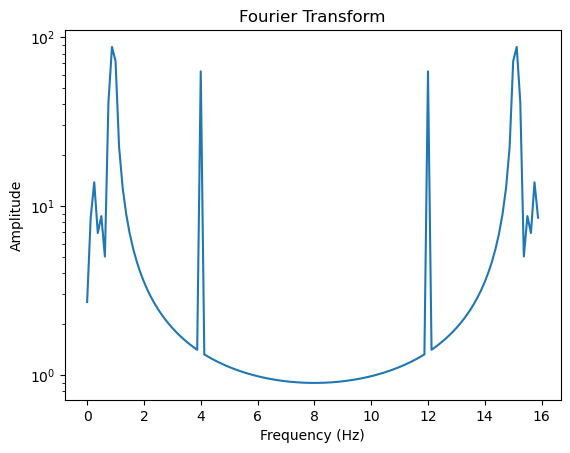

In [15]:
# Now again we copy code from above

# To apply the high-pass-filter in the time-domain we use convolution. Now we do not assume the data is cyclical
high_passed_data = np.zeros(len(times) - len(high_pass_filter_windowed_time_domain))
# This is a convolution. There are numpy functions for this, but let's demonstrate it first
for i in range(len(high_passed_data)):
    for j in range(len(high_pass_filter_windowed_time_domain)):
        k = i + j
        high_passed_data[i] += high_pass_filter_windowed_time_domain[j] * data_time_domain[k]

# Now let's plot an 8-second stretch of this data
high_passed_data_window_CUT = high_passed_data[504*sample_rate:(504+data_length_CUT)*sample_rate]

plt.figure()
plt.plot(times_CUT, high_passed_data_window_CUT, label='Data')
plt.plot(times_CUT, signal_CUT, label='signal')
plt.legend()
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(high_passed_data_window_CUT)
plt.semilogy(frequencies_CUT, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

## A longer filter

This is looking pretty good now, but we still haven't properly removed the low-frequency noise. Let's try making the filter longer - we will remake the plots along the way

Text(0, 0.5, 'Amplitude')

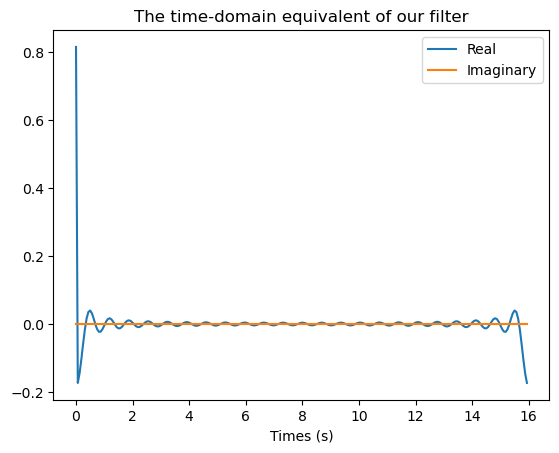

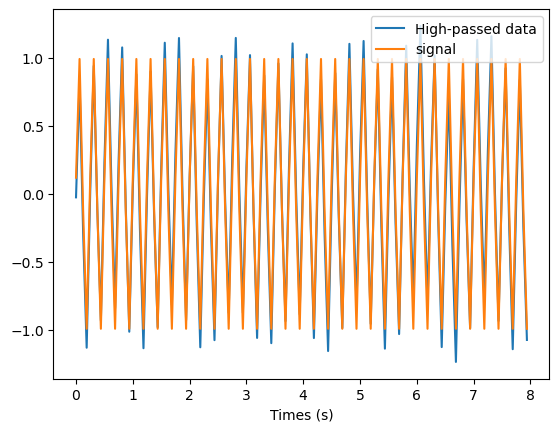

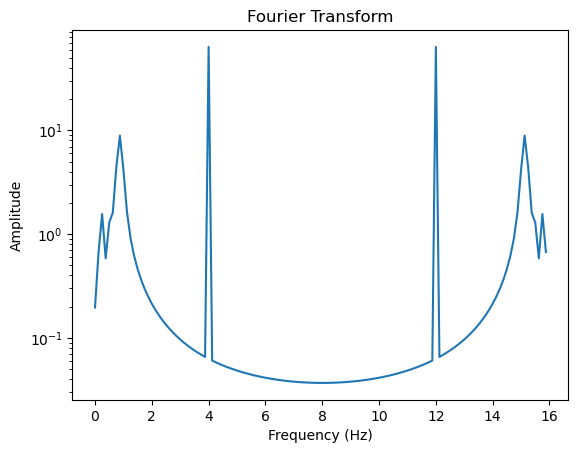

In [16]:
# We want to apply the following "filter" to our data.
# Plotted in both f- and t- domains
# and then rotated forward.

# This is doubling the length of the filter from before:
high_pass_filter = np.zeros(data_length_CUT * 2 * sample_rate, dtype=np.complex128)
frequencies_filter = np.arange(data_length_CUT * 2 * sample_rate) / (data_length_CUT*2)
times_filter = np.arange(data_length_CUT * 2 * sample_rate) / sample_rate

high_pass_filter[int(1.5*data_length_CUT*2):-(int(1.5*data_length_CUT*2) - 1)] = 1

# Let plot this in the time domain
high_pass_filter_time_domain = compute_inverse_fourier_transform(high_pass_filter)
plt.figure()
plt.title("The time-domain equivalent of our filter")
plt.plot(times_filter, high_pass_filter_time_domain.real)
plt.plot(times_filter, high_pass_filter_time_domain.imag)
plt.legend(['Real', 'Imaginary'])
plt.xlabel("Times (s)")

# The filter is cyclical in the time domain so we can shift it forward 128 cycles. We do this to put the
# peak of the filter in the middle, so that when we apply this to a longer stretch of data we minimize the effect
# of the discontinuity. We also remove the imaginary component, as it's 0 anyway
tmp = np.zeros(len(high_pass_filter_time_domain))
half_len = len(high_pass_filter_time_domain) // 2
tmp[half_len:] = high_pass_filter_time_domain[:half_len].real
tmp[:half_len] = high_pass_filter_time_domain[half_len:].real
high_pass_filter_time_domain = tmp


# Now we multiply our filter by a "Hann" window to force it to go to 0
high_pass_filter_windowed_time_domain = np.copy(high_pass_filter_time_domain)
for i in range(len(high_pass_filter_windowed_time_domain)):
    window_func = 0.5 * (1 - np.cos(2*np.pi*i/ (len(high_pass_filter_windowed_time_domain)-1) ) )
    high_pass_filter_windowed_time_domain[i] = high_pass_filter_windowed_time_domain[i] * window_func


# What does this look like now in the frequency domain?
data_frequency_domain = compute_fourier_transform(high_pass_filter_time_domain)


# To apply the high-pass-filter in the time-domain we use convolution.
# Now we do *not* assume the data is cyclical
high_passed_data = np.zeros(len(times) - len(high_pass_filter_windowed_time_domain))
# This is a convolution. There are numpy functions for this, but let's demonstrate it first
for i in range(len(high_passed_data)):
    for j in range(len(high_pass_filter_windowed_time_domain)):
        k = i + j
        high_passed_data[i] += high_pass_filter_windowed_time_domain[j] * data_time_domain[k]

# Now let's plot the middle 8-second stretch of this data
high_passed_data_CUT = high_passed_data[504*sample_rate:(504+data_length_CUT)*sample_rate]

plt.figure()
plt.plot(times_CUT, high_passed_data_CUT, label="High-passed data")
plt.plot(times_CUT, signal_CUT, label='signal')
plt.legend()
plt.xlabel("Times (s)")

plt.figure()
data_frequency_domain = compute_fourier_transform(high_passed_data_CUT)
plt.semilogy(frequencies_CUT, abs(data_frequency_domain))
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')


And with this we have managed to recover the original signal reasonably well from the data! There is still some noise present, but the data is now dominated by the 4Hz signal that we wanted to recover. Better windowing/filter would do a better job of extracting this signal, but we'll leave this example here for now.

SUMMARY: This was a long example. What are the main points we are trying to get across here?

* High-pass filtering real data has a *lot* of subtleties, and can never be done perfectly. This is not just a plug-and-play and expect everything to work brilliantly type of situation.
* Designing an appropriate filter for different operations has a lot of tunable parameters. How long should the filter be? How aggressively do I window it? What window do I use? How sharp do I need the filter to be?
* Scipy, in particular, provides some really nice functionality to automatically make appropriate filters. For the most part, you would just use scipy for this kind of thing, but getting a sense of the kind of decisions that it must make, and hide from you, is important to knowing why it doesn't work if you make certain choices!
